# Introduction to gQuant

**gQuant** is a set of open-source examples for Quantitative Analysis tasks:
- Data preparation & feat. engineering
- Alpha seeking modeling
- Technical indicators
- Backtesting

It is GPU-accelerated by leveraging [**RAPIDS.ai**](https://rapids.ai) technology, and has Multi-GPU and Multi-Node support.

gQuant computing components are oriented around its plugins and task graph.

## Download example datasets

Before getting started, let's download the example datasets if not present.

In [1]:
! ((test ! -f './data/stock_price_hist.csv.gz' ||  test ! -f './data/security_master.csv.gz') && \
  cd .. && bash download_data.sh) || echo "Dataset is already present. No need to re-download it."

Dataset is already present. No need to re-download it.


## About this notebook

In this tutorial, we are going to use gQuant to do a simple quant job. The job tasks are listed below:
    1. load csv stock data.
    2. filter out the stocks that has average volume smaller than 50.
    3. sort the stock symbols and datetime.
    4. add rate of return as a feature into the table.
    5. in two branches, computethe mean volume and mean return.
    6. read the file containing the stock symbol names, and join the computed dataframes.
    7. output the result in csv files.
    
## Task graphs, nodes and plugins

Quant processing operators are defined as nodes that operates on **cuDF**/**dask_cuDF** dataframes.

A **task graph** is a list of tasks composed of gQuant nodes.

The cell below contains the task graph described before.

In [2]:
import sys; sys.path.insert(0, '..')
import warnings; warnings.simplefilter("ignore")

from gquant.dataframe_flow import TaskSpecSchema 

# load csv stock data
task_csvdata = {
    TaskSpecSchema.task_id: 'load_csv_data',
    TaskSpecSchema.node_type: 'CsvStockLoader',
    TaskSpecSchema.conf: {'path': './data/stock_price_hist.csv.gz'},
    TaskSpecSchema.inputs: []
}

# filter out the stocks that has average volume smaller than 50
task_minVolume = {
    TaskSpecSchema.task_id: 'min_volume',
    TaskSpecSchema.node_type: 'VolumeFilterNode',
    TaskSpecSchema.conf: {'min': 50.0},
    TaskSpecSchema.inputs: ['load_csv_data']
}

# sort the stock symbols and datetime
task_sort = {
    TaskSpecSchema.task_id: 'sort',
    TaskSpecSchema.node_type: 'SortNode',
    TaskSpecSchema.conf: {'keys': ['asset', 'datetime']},
    TaskSpecSchema.inputs: ['min_volume']
}

# add rate of return as a feature into the table
task_addReturn = {
    TaskSpecSchema.task_id: 'add_return',
    TaskSpecSchema.node_type: 'ReturnFeatureNode',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: ['sort']
}

# read the stock symbol name file and join the computed dataframes
task_stockSymbol = {
    TaskSpecSchema.task_id: 'stock_symbol',
    TaskSpecSchema.node_type: 'StockNameLoader',
    TaskSpecSchema.conf: {'path': './data/security_master.csv.gz'},
    TaskSpecSchema.inputs: []
}

# In two branches, compute the mean volume and mean return seperately
task_volumeMean = {
    TaskSpecSchema.task_id: 'volume_mean',
    TaskSpecSchema.node_type: 'AverageNode',
    TaskSpecSchema.conf: {'column': 'volume'},
    TaskSpecSchema.inputs: ['add_return']
}

task_returnMean = {
    TaskSpecSchema.task_id: 'return_mean',
    TaskSpecSchema.node_type: 'AverageNode',
    TaskSpecSchema.conf: {'column': 'returns'},
    TaskSpecSchema.inputs: ['add_return']
}

task_leftMerge1 = {
    TaskSpecSchema.task_id: 'left_merge_1',
    TaskSpecSchema.node_type: 'LeftMergeNode',
    TaskSpecSchema.conf: {'column': 'asset'},
    TaskSpecSchema.inputs: ['volume_mean', 'stock_symbol']
}

task_leftMerge2 = {
    TaskSpecSchema.task_id: 'left_merge_2',
    TaskSpecSchema.node_type: 'LeftMergeNode',
    TaskSpecSchema.conf: {'column': 'asset'},
    TaskSpecSchema.inputs: ['return_mean', 'stock_symbol']
}

# output the result in csv files

task_outputCsv1 = {
    TaskSpecSchema.task_id: 'output_csv_1',
    TaskSpecSchema.node_type: 'OutCsvNode',
    TaskSpecSchema.conf: {'path': 'symbol_volume.csv'},
    TaskSpecSchema.inputs: ['left_merge_1']
}

task_outputCsv2 = {
    TaskSpecSchema.task_id: 'output_csv_2',
    TaskSpecSchema.node_type: 'OutCsvNode',
    TaskSpecSchema.conf: {'path': 'symbol_returns.csv'},
    TaskSpecSchema.inputs: ['left_merge_2']
}

In Python, a gQuant task-spec is defined as a dictionary with the following fields:
- `id`
- `type`
- `conf`
- `inputs`
- `filepath`

As a best practice, we recommend using the `TaskSpecSchema` class for these fields, instead of strings.

The `id` for a given task must be unique within a task graph. To use the result(s) of other task(s) as input(s) of a different task, we use the id(s) of the former task(s) in the `inputs` field of the next task.

The `type` field contains the node type to use for the compute task. gQuant includes a collection of node classes. These can be found in `gquant.plugin_nodes`. Click [here](#node_class_example) to see a gQuant node class example.

The `conf` field is used to parameterise a task. It lets you access user-set parameters within a plugin (such as `self.conf['min']` in the example above).

The `filepath` field is used to specify a python module where a custom plugin is defined. It is optional if the plugin is in `plugin_nodes` directory, and mandatory when the plugin is somewhere else. In a different tutorial, we will learn how to create custom plugins.

A custom node schema will look something like this:
```
custom_task = {
    TaskSpecSchema.task_id: 'custom_calc',
    TaskSpecSchema.node_type: 'CustomNode',
    TaskSpecSchema.conf: {},
    TaskSpecSchema.inputs: ['some_other_node'],
    TaskSpecSchema.filepath: 'custom_nodes.py'
}
```

Below, we compose our task graph and visualize it as a graph.

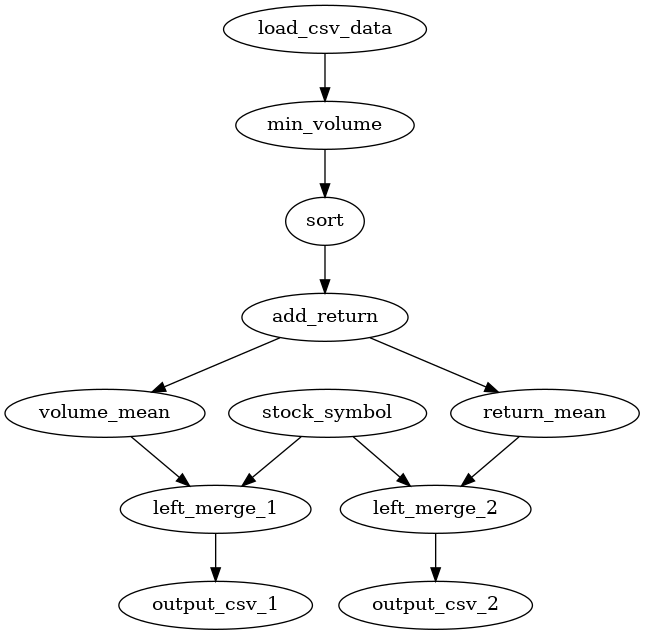

In [3]:
from gquant.dataframe_flow import TaskGraph

# list of nodes composing the task graph
task_list = [
    task_csvdata, task_minVolume, task_sort, task_addReturn,
    task_stockSymbol, task_volumeMean, task_returnMean,
    task_leftMerge1, task_leftMerge2,
    task_outputCsv1, task_outputCsv2]

task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

We will use `save_taskgraph` method to save the task graph to a **yaml file**.

That will allow us to re-use it in the future.

In [4]:
task_graph_file_name = '01_tutorial_task_graph.yaml'

task_graph.save_taskgraph(task_graph_file_name)

Here is a snippet of the content in the resulting yaml file:

In [5]:
%%bash -s "$task_graph_file_name"
head -n 19 $1

- id: load_csv_data
  type: CsvStockLoader
  conf:
    path: ./data/stock_price_hist.csv.gz
  inputs: []
- id: min_volume
  type: VolumeFilterNode
  conf:
    min: 50.0
  inputs:
  - load_csv_data
- id: sort
  type: SortNode
  conf:
    keys:
    - asset
    - datetime
  inputs:
  - min_volume


The yaml file describes the computation tasks. We can load it and visualize it as a graph.

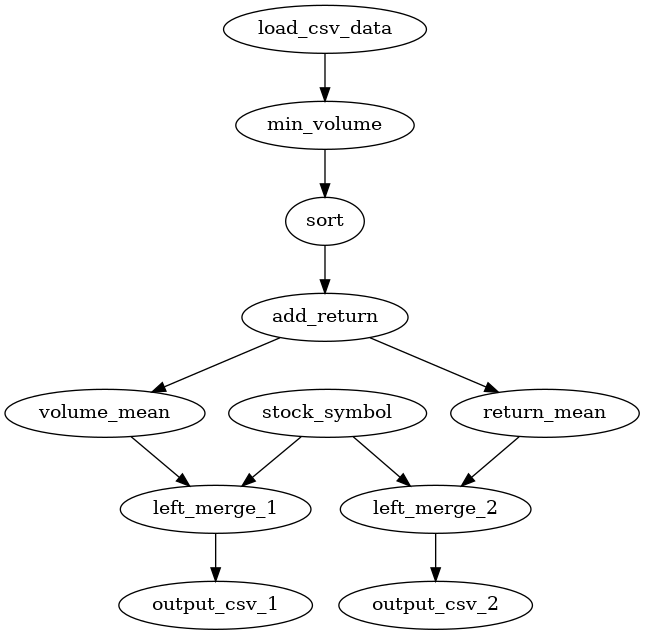

In [6]:
task_graph = TaskGraph.load_taskgraph(task_graph_file_name)
task_graph.draw(show='ipynb')

## Building a task graph

Running the task graph is the next logical step. Nevertheless, it can optionally be built before running it.

By calling `build` method, the graph is traversed without running the dataframe computations. This could be useful to inspect the column names and types, validate that the plugins can be instantiated, and check for errors.

The output of `build` are instances of each task in a dictionary.

In the example below, we inspect the column names and types for the inputs and outputs of the `left_merge_1` task:

In [7]:
from pprint import pprint

task_graph.build()

print('Output of build task graph are instances of each task in a dictionary:\n')
print(str(task_graph))

Output of build task graph are instances of each task in a dictionary:

load_csv_data: <NodeInTaskGraph gquant.plugin_nodes.dataloader.csvStockLoader.CsvStockLoader object at 0x7fedff3fb898>
min_volume: <NodeInTaskGraph gquant.plugin_nodes.transform.volumeFilterNode.VolumeFilterNode object at 0x7fedff439390>
sort: <NodeInTaskGraph gquant.plugin_nodes.transform.sortNode.SortNode object at 0x7fedf9c1c1d0>
add_return: <NodeInTaskGraph gquant.plugin_nodes.transform.returnFeatureNode.ReturnFeatureNode object at 0x7fedf9c1c390>
stock_symbol: <NodeInTaskGraph gquant.plugin_nodes.dataloader.stockNameLoader.StockNameLoader object at 0x7fedf9c1c588>
volume_mean: <NodeInTaskGraph gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7fedf9c1c780>
return_mean: <NodeInTaskGraph gquant.plugin_nodes.transform.averageNode.AverageNode object at 0x7fedf9c1c978>
left_merge_1: <NodeInTaskGraph gquant.plugin_nodes.transform.leftMergeNode.LeftMergeNode object at 0x7fedf9c1cb70>
left_merge_2: <No

In [8]:
# Input columns in 'left_merge_1' node

print('Input columns in incoming dataframes:\n')
pprint(task_graph['left_merge_1'].input_columns)

Input columns in incoming dataframes:

{0: {'asset': 'int64', 'volume': 'float64'},
 1: {'asset': 'int64', 'asset_name': 'object'}}


In [9]:
# Output columns in 'left_merge_1' node

print('Output columns in outgoing dataframe:\n')
pprint(task_graph['left_merge_1'].output_columns)

Output columns in outgoing dataframe:

{'asset': 'int64', 'asset_name': 'object', 'volume': 'float64'}


## Running a task graph

To execute the graph computations, we will use the `run` method.

It requires a tasks list and outputs list. `run` can also takes an optional `replace` argument which is used and explained later on.

In [10]:
outputs = ['load_csv_data', 'output_csv_1', 'output_csv_2']
csv_data_df, csv_1_df, csv_2_df = task_graph.run(outputs=outputs)

We can profile each of the computation node running time by turning on the profiler.

In [11]:
outputs = ['load_csv_data', 'output_csv_1', 'output_csv_2']
csv_data_df, csv_1_df, csv_2_df = task_graph.run(outputs=outputs, profile=True)

id:load_csv_data process time:3.874s
id:min_volume process time:0.199s
id:sort process time:0.125s
id:add_return process time:0.221s
id:volume_mean process time:0.050s
id:return_mean process time:0.045s
id:stock_symbol process time:0.015s
id:left_merge_1 process time:0.003s
id:output_csv_1 process time:0.020s
id:left_merge_2 process time:0.003s
id:output_csv_2 process time:0.020s


Where most of the time is spent on the csv file processing. This is because we have to convert the time string to the proper format via CPU. Let's inspect the content of `csv_1_df` and `csv_2_df`.

In [12]:
print('csv_1_df content:')
print(csv_1_df)

print('\ncsv_2_df content:')
print(csv_2_df)   

csv_1_df content:
       asset       volume asset_name
0     869584   673.625235        LPT
1     869589   110.456066       DSLV
2     869590    66.607253       BPTH
3     869592    56.041766         SP
4     869349    91.161991       VIIX
...      ...          ...        ...
3679    5890  1386.894587        DRI
3680    5891   164.916612        DRL
3681    5893   336.161817        DRQ
3682    5896   453.901682        DSL
3683    5897    82.365824        DSM

[3684 rows x 3 columns]

csv_2_df content:
       asset   returns asset_name
0     869584  0.000369        LPT
1     869589  0.001077       DSLV
2     869590  0.005321       BPTH
3     869592  0.000502         SP
4     708893 -0.000588        UCP
...      ...       ...        ...
3679   23748  0.001471       FBHS
3680   23750 -0.000059        BUI
3681   23752  0.006837       TEAR
3682   23755  0.000506        PUK
3683   23762  0.003529       TPLM

[3684 rows x 3 columns]


Also, please notice that two resulting csv files has been created:
- symbol_returns.csv
- symbol_volume.csv

In [13]:
print('\ncsv files created:')
!find . -iname "*symbol*" 


csv files created:
./symbol_returns.csv
./symbol_volume.csv


## Subgraphs

A nice feature of task graphs is that we can evaluate any **subgraph**. For instance, if you are only interested in the `volume_mean` result, you can run only the tasks which are relevant for that computation.

If we would not want to re-run tasks, we could also use the `replace` argument of the `run` function with a `load` option.

The `replace` argument needs to be a dictionary where each key is the task/node id. The values are a replacement task-spec dictionary (i.e. each key is a spec overload, and its value is what to overload with).

In the example below, instead of re-running the `load_csv_data` node to load a csv file into a `cudf` dataframe, we will use its dataframe output to load from it.

In [14]:
replace = {
    'load_csv_data': {
        'load': csv_data_df,
        'save': True
    }
}

(volume_mean_df, ) = task_graph.run(outputs=['volume_mean'],
                                    replace=replace)

print(volume_mean_df)

       asset        volume
0        631    350.260026
1        914    266.223774
2       1404   2073.529168
3       1544     80.659223
4       1545  18922.826861
...      ...           ...
3679  869577    147.814845
3680  869584    673.625235
3681  869589    110.456066
3682  869590     66.607253
3683  869592     56.041766

[3684 rows x 2 columns]


As a convenience, we can save on disk the checkpoints for any of the nodes, and re-load them if needed. It is only needed to set the save option to `True`.

In the example above, the `replace` spec directs `run` to save on disk for the `load_csv_data`. If `load` was boolean then the data would be loaded from disk presuming the data was saved to disk in a prior run.

The default directory for saving is `<current_workdir>/.cache/<node_id>.hdf5`.

`replace` is also used to override parameters in the tasks. For instance, if we wanted to use the value `40.0` instead `50.0` in the task `min_volume`, we would do something similar to:
```
replace_spec = {
    'min_volume': {
        'conf': {
            'min': 40.0
        }
    },
    'some_task': etc...
}
```

In [15]:
replace = {'load_csv_data': {'load': True},
           'return_mean': {'save': True}}


(return_mean_df, ) = task_graph.run(outputs=['return_mean'], replace=replace)

print('Return mean Dataframe:\n')
print(return_mean_df)

Return mean Dataframe:

       asset   returns
0        631  0.000026
1        914 -0.000893
2       1404  0.000423
3       1544  0.001153
4       1545  0.000784
...      ...       ...
3679  869577 -0.000276
3680  869584  0.000369
3681  869589  0.001077
3682  869590  0.005321
3683  869592  0.000502

[3684 rows x 2 columns]


Now, we might want to load the `return_mean_df` from the saved file and evaluate only tasks that we are interested in.

In the cells below, we compare different load approaches:
- in-memory,
- from disk, 
- and not loading at all.

When working interactively, or in situations requiring iterative and explorative task graphs, a significant amount of time is saved by just re-loading the data that do not require to be recalculated.

In [16]:
%%time
print('Using in-memory dataframes for load:')

replace = {'load_csv_data': {'load': csv_data_df},
           'return_mean': {'load': return_mean_df}}

_ = task_graph.run(outputs=['output_csv_2'], replace=replace)

Using in-memory dataframes for load:
CPU times: user 51 ms, sys: 804 µs, total: 51.8 ms
Wall time: 49.8 ms


In [17]:
%%time
print('Using cached dataframes on disk for load:')

replace = {'load_csv_data': {'load': True},
           'return_mean': {'load': True}}

_ = task_graph.run(outputs=['output_csv_2'], replace=replace)

Using cached dataframes on disk for load:
CPU times: user 61 ms, sys: 716 µs, total: 61.7 ms
Wall time: 59.2 ms


In [18]:
%%time
print('Re-running dataframes calculations instead of using load:')

replace = {'load_csv_data': {'load': True}}

_ = task_graph.run(outputs=['output_csv_2'], replace=replace)

Re-running dataframes calculations instead of using load:
CPU times: user 873 ms, sys: 691 ms, total: 1.56 s
Wall time: 1.63 s


An idiomatic way to save data, if not on disk, or load data, if present on disk, is demonstrated below.

In [19]:
%%time
import os

loadsave_csv_data    = 'load' if os.path.isfile('./.cache/load_csv_data.hdf5') else 'save'
loadsave_return_mean = 'load' if os.path.isfile('./.cache/return_mean.hdf5') else 'save'

replace = {'load_csv_data': {loadsave_csv_data: True},
           'return_mean': {loadsave_return_mean: True}}

_ = task_graph.run(outputs=['output_csv_2'], replace=replace)

CPU times: user 50.5 ms, sys: 8.23 ms, total: 58.8 ms
Wall time: 56.2 ms


## Delete temporary files

A few cells above, we generated a .yaml file containing the example task graph, and also a couple of CSV files.

Let's keep our directory clean, and delete them.

In [20]:
%%bash -s "$task_graph_file_name"
rm -f $1 symbol_returns.csv symbol_volume.csv # clean up

<a id='node_class_example'></a>

---

## Node class example

Implementing custom nodes in gQuant is very straighforward.

Data scientists only need to override two methods in the parent class `Node`:
- `columns_setup`
- `process`

`columns_setup` method  is used to define the required column names and types for both input and output dataframes.

`process` method takes input dataframes and computes the output dataframe. 

In this way, dataframes are strongly typed, and errors can be detected early before the time-consuming computation happens.

Below, it can be observed `VolumeFilterNode` implementation details:

In [21]:
import inspect
from gquant.plugin_nodes.transform import VolumeFilterNode

print(inspect.getsource(VolumeFilterNode))

class VolumeFilterNode(Node):

    def columns_setup(self):
        self.required = {"asset": "int64",
                         "volume": "float64"}
        self.addition = {"mean_volume": "float64"}

    def process(self, inputs):
        """
        filter the dataframe based on the min and max values of the average
        volume for each fo the assets.

        Arguments
        -------
         inputs: list
            list of input dataframes.
        Returns
        -------
        dataframe
        """

        input_df = inputs[0]
        volume_df = input_df[['volume', "asset"]].groupby(
                ["asset"]).mean().reset_index()
        volume_df.columns = ["asset", 'mean_volume']
        merged = input_df.merge(volume_df, on="asset", how='left')
        if 'min' in self.conf:
            minVolume = self.conf['min']
            merged = merged.query('mean_volume >= %f' % (minVolume))
        if 'max' in self.conf:
            maxVolume = self.conf['max']
            me